# Popis notebooku
Chtěl bych v následujících krocích popsat můj postup a myšlenkové pochody pro usnadnění orientace v kódu.
- Nejprve jsem vytvořil základní verzi algoritmu, kdy jsem měl pouze pole a sýr, když jsem ověřil základní činnost, že jsem byl schopný se dostat k sýru, tak jsem přidal zdi a potom pastičky.
- Všimnul jsem si že v zadání je zmínka jenom o holes což jsou v tomto případě pastičky.
- Ze začátku jsem měl příliš velkou penalizaci agenta a tak jsem ho vystrašil a stalo se mi že se bál pohnout, což je celkem vtipné : D
- Předělal jsem to a zmenšil penalizaci za pastičky a přidal malé odměny za to že se hýbe.
- Moje mapy jsou náhodně generované a tak bylo třeba ověřit že existuje alespoň jedna cesta k sýru, pro to jsem použil bfs algoritmus.
- Přidal jsem vykreslení animace pohybu, kdyžtak dole v poslední bunce můžete vidět staré vykreslení kdy jsem už jenom testoval -> explorace nastavena na 0
  
- Ještě odpověď na otázku, většinou v rámci 100 až 300 epizod se odměna a Q matice stabilizovaly a tak došlo k vytrénování. 
- Animaci cesty najdete na agent_path.gif

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from PIL import Image
import io

# Parametry Q-learningu
alpha = 0.3  # Zvýšená učící rychlost
gamma = 0.7  # Snížený diskontní faktor
epsilon = 0.3  # Vyšší epsilon pro exploraci v počátečních epizodách
episodes = 1000  # počet trénovacích epizod
grid_size = 5  # Velikost mřížky (5x5)
actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]  # nahoru, dolů, vpravo, vlevo

# Q-matrice
Q = np.zeros((grid_size, grid_size, len(actions)))

# Pozice sýra (Cíl)
cheese_pos = (4, 4)

# Funkce pro vykreslení herní mřížky
def plot_grid(agent_pos, cheese_pos, obstacles, holes):
    grid = np.zeros((grid_size, grid_size))
    grid[cheese_pos] = 2  # Sýr
    grid[agent_pos] = 1   # Agent
    for obs in obstacles:
        grid[obs] = -1  # Překážky
    for hole in holes:
        grid[hole] = -2  # Díry
    return grid

# Funkce pro kontrolu cesty z (0, 0) do sýra pomocí BFS
def is_path_available(start, cheese_pos, obstacles, holes):
    # BFS pro hledání cesty
    visited = set()
    queue = deque([start])

    while queue:
        current = queue.popleft()
        if current == cheese_pos:
            return True  # Cesta k sýru existuje
        
        for action in actions:
            next_state = (current[0] + action[0], current[1] + action[1])
            if (0 <= next_state[0] < grid_size and
                0 <= next_state[1] < grid_size and
                next_state not in visited and
                next_state not in obstacles and
                next_state not in holes):
                visited.add(next_state)
                queue.append(next_state)
    
    return False  # Cesta k sýru neexistuje

# Funkce pro generování mapy, která má alespoň jednu cestu
def generate_map():
    # Generování překážek
    num_obstacles = 5
    obstacles = set()
    while len(obstacles) < num_obstacles:
        obs_pos = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        if obs_pos != cheese_pos and obs_pos != (0, 0):  # Zajistíme, že překážka není na pozici sýra nebo startu
            obstacles.add(obs_pos)

    # Generování děr
    num_holes = 3
    holes = set()
    while len(holes) < num_holes:
        hole_pos = (random.randint(0, grid_size-1), random.randint(0, grid_size-1))
        if hole_pos != cheese_pos and hole_pos != (0, 0) and hole_pos not in obstacles:  # Zajistíme, že díra není na startu nebo sýru
            holes.add(hole_pos)

    return obstacles, holes

# Funkce pro generování mapy, která má alespoň jednu dostupnou cestu k sýru
def generate_valid_map():
    while True:
        # Generování nové mapy s překážkami a děrami
        obstacles, holes = generate_map()
        
        # Kontrola, zda existuje alespoň jedna cesta k sýru
        if is_path_available((0, 0), cheese_pos, obstacles, holes):
            return obstacles, holes  # Pokud cesta existuje, vrátíme mapu
        else:
            # Pokud cesta neexistuje, vygenerujeme novou mapu
            continue

# Funkce pro výběr akce (epsilon-greedy)
def choose_action(state, epsilon):
    if random.uniform(0, 1) < epsilon:
        return random.choice(range(len(actions)))  # Prozkoumání
    else:
        return np.argmax(Q[state[0], state[1]])  # Exploatace

# Funkce pro aktualizaci Q-matice
def update_Q(state, action, reward, next_state, alpha, gamma):
    max_future_q = np.max(Q[next_state[0], next_state[1]])
    current_q = Q[state[0], state[1], action]
    Q[state[0], state[1], action] = current_q + alpha * (reward + gamma * max_future_q - current_q)

# Funkce pro simulaci jedné epizody
def run_episode(alpha, gamma, epsilon, obstacles, holes):
    state = (0, 0)  # Začátek na pozici (0, 0)
    total_reward = 0
    path = [state]  # Uchováme všechny pozice pro animaci
    while state != cheese_pos:
        action = choose_action(state, epsilon)
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        
        # Omezíme pohyb na mřížku
        next_state = (max(0, min(grid_size-1, next_state[0])), max(0, min(grid_size-1, next_state[1])))
        
        # Zkontrolujeme, jestli agent narazil na překážku nebo díru
        if next_state in obstacles:
            next_state = state  # Agent zůstane na místě, pokud narazí na překážku
            reward = -1  # Za ztracený krok na překážce je penalizace
        elif next_state in holes:
            reward = -10  # Větší penalizace za díru
            break  # Hra končí, pokud agent šlápne na díru
        else:
            # Odměna za dosažení sýra
            if next_state == cheese_pos:
                reward = 100  # Velká odměna za dosažení sýra
            else:
                # Malá odměna za vyhýbání se dírám a překážkám
                reward = 1  # Odměna za bezpečný pohyb
            
        # Uchováme pozici pro animaci
        path.append(next_state)
        
        # Aktualizace Q-matice
        update_Q(state, action, reward, next_state, alpha, gamma)
        state = next_state
        total_reward += reward
    return total_reward, path

# Funkce pro snížení epsilon v průběhu trénování
def update_epsilon(epsilon, decay=0.995, min_epsilon=0.01):
    return max(min_epsilon, epsilon * decay)

# Funkce pro vytváření GIFu z pohybu agenta
def create_gif(path, obstacles, holes):
    images = []
    for pos in path:
        grid = plot_grid(pos, cheese_pos, obstacles, holes)
        
        # Uložíme obrázek do souboru
        fig = plt.figure(figsize=(5, 5))
        plt.imshow(grid, cmap='hot', interpolation='nearest')
        plt.axis('off')  # Skryjeme osy
        plt.title("Agent's Path")
        
        # Zajistíme, že grid bude mít správný formát pro generování obrázku
        plt.tight_layout()
        
        # Uložíme obrázek do dočasného souboru a načteme jej pomocí Pillow
        img_path = '/tmp/temp_image.png'
        plt.savefig(img_path)
        plt.close(fig)
        
        # Načteme obrázek a přidáme ho do seznamu snímků
        img = Image.open(img_path)
        images.append(img)
    
    # Uložíme snímky jako GIF
    images[0].save('agent_path.gif', save_all=True, append_images=images[1:], duration=500, loop=0)

# Funkce pro vykreslení Q-matice
def plot_q_matrix(Q, episode=10):
    plt.imshow(Q[:, :, 0], cmap='hot', interpolation='nearest')  # Zobrazení Q-matice pro první akci (nahoru)
    plt.colorbar()
    plt.title(f"Q-matice po {episode} epizodách")
    plt.show()

# Funkce pro vytváření GIFu z Q-matice
def create_q_matrix_gif():
    images = []
    
    for episode in range(0, episodes, 50):  # Save every 50th episode's Q-matrix
        fig = plot_q_matrix(Q, episode)
        
        # Convert the plot to an in-memory image
        buf = io.BytesIO()  # Create a buffer to hold the image data
        plt.savefig(buf, format='png')  # Save the plot to the buffer as a PNG image
        buf.seek(0)  # Go to the beginning of the buffer
        
        # Read the image from the buffer and append it to the images list
        img = Image.open(buf)
        images.append(img)
        
        plt.close(fig)  # Close the figure to avoid memory issues
    
    # Save the images as a GIF
    if images:
        images[0].save('q_matrix_animation.gif', save_all=True, append_images=images[1:], duration=500, loop=0)





Epizoda 0, Celková odměna: -5


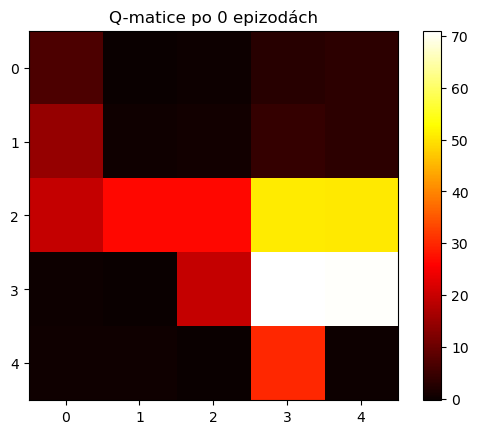

Epizoda 100, Celková odměna: 107


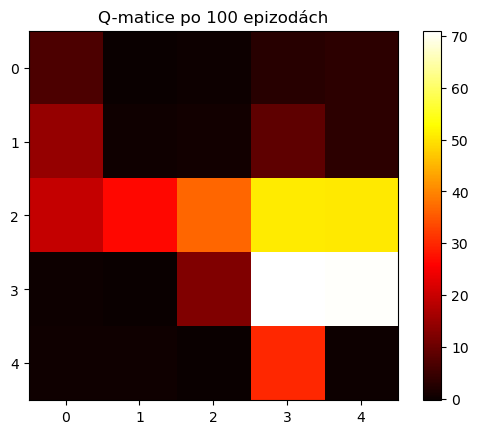

Epizoda 200, Celková odměna: 107


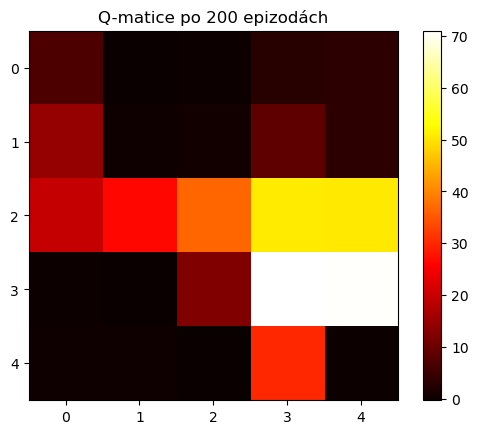

Epizoda 300, Celková odměna: 107


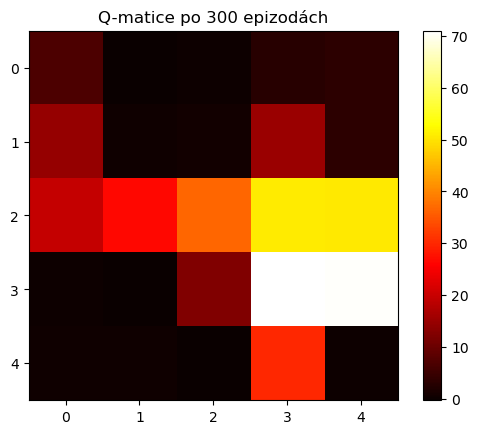

Epizoda 400, Celková odměna: 107


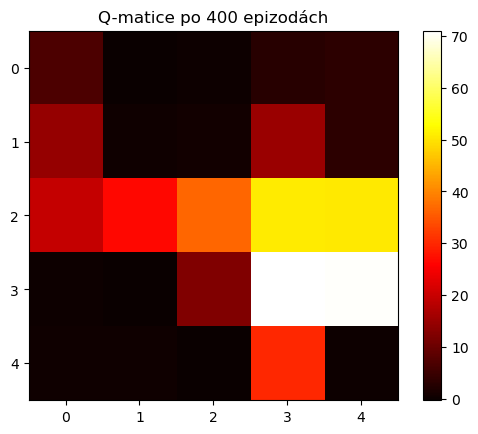

Epizoda 500, Celková odměna: 107


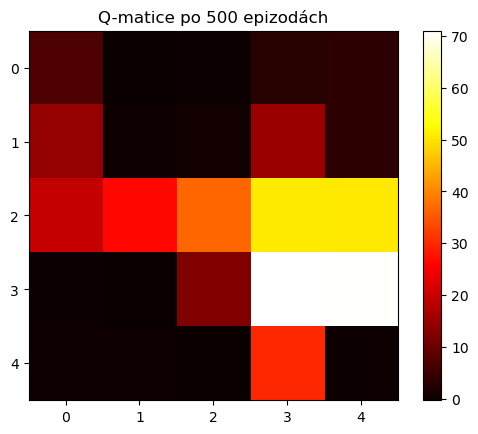

Epizoda 600, Celková odměna: 107


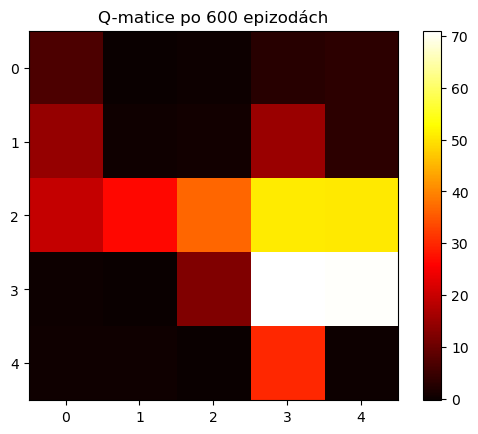

Epizoda 700, Celková odměna: 107


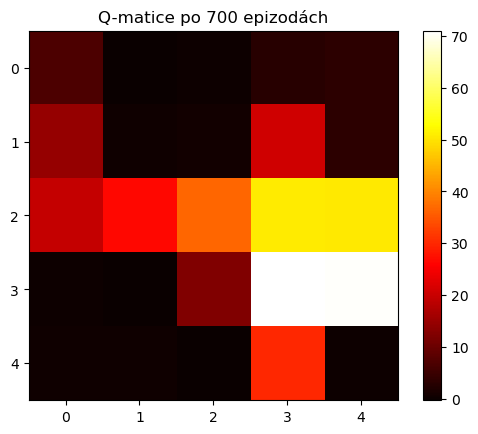

Epizoda 800, Celková odměna: 107


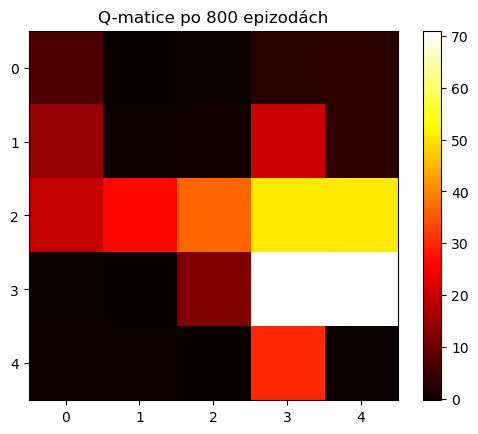

Epizoda 900, Celková odměna: 107


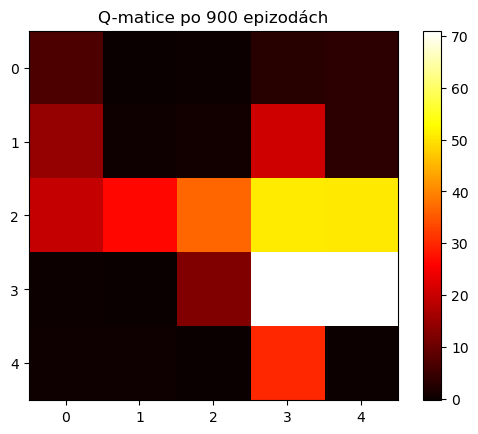

In [5]:
# Generování validní mapy před trénováním
obstacles, holes = generate_valid_map()
plot_grid((0,0), cheese_pos, obstacles, holes)
# Trénování agenta
rewards = []  # Seznam pro ukládání odměn v jednotlivých epizodách
for episode in range(episodes):
    total_reward, path = run_episode(alpha, gamma, epsilon, obstacles, holes)
    rewards.append(total_reward)
    epsilon = update_epsilon(epsilon)  # Snížení epsilon v průběhu trénování
    
    # Vizualizace Q-matice po každých 100 epizodách
    if episode % 100 == 0:
        print(f"Epizoda {episode}, Celková odměna: {total_reward}")
        plot_q_matrix(Q, episode)  # Vizualizace Q-matice

# Vytvoříme GIF pohybu agenta
create_gif(path, obstacles, holes)

# Vytvoříme GIF z Q-matice
#create_q_matrix_gif()

Celková odměna: 93


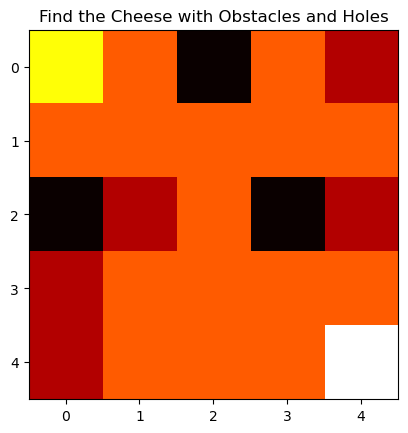

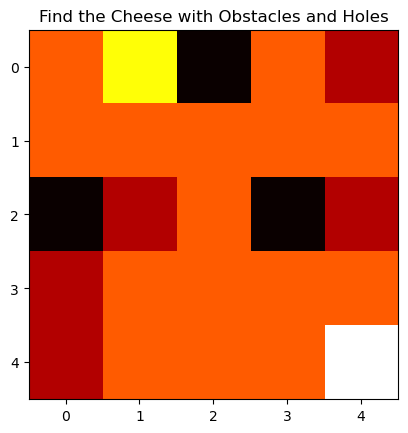

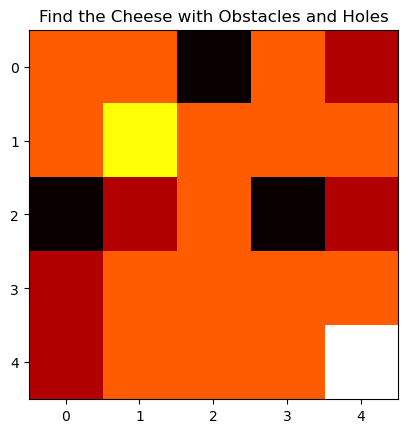

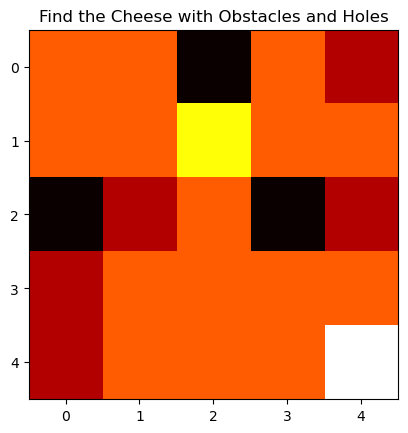

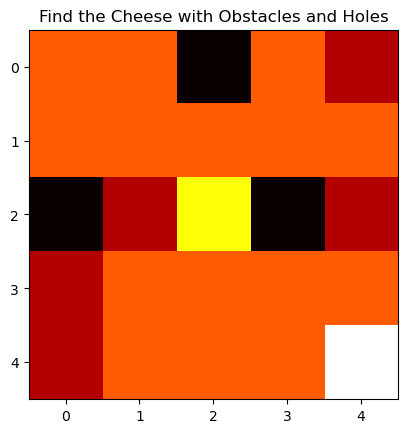

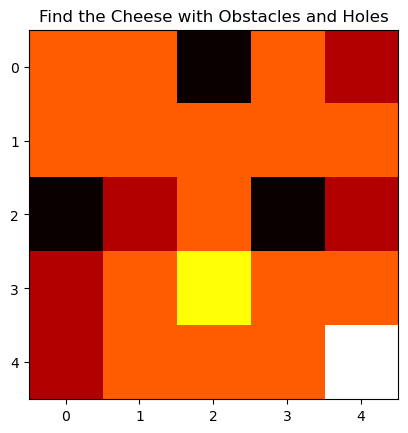

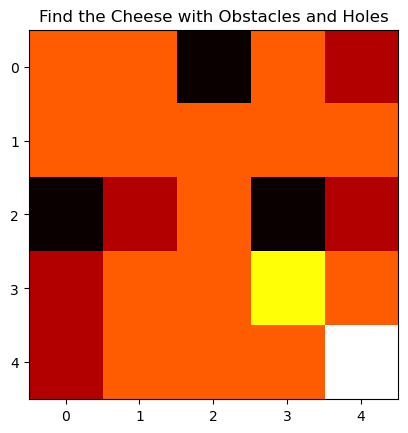

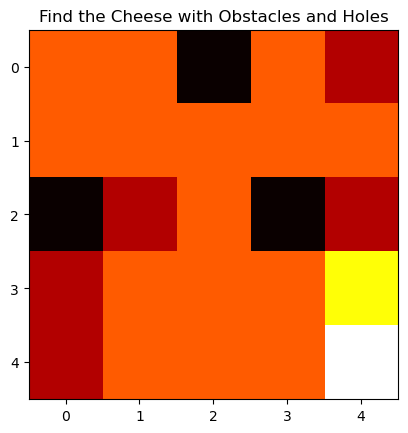

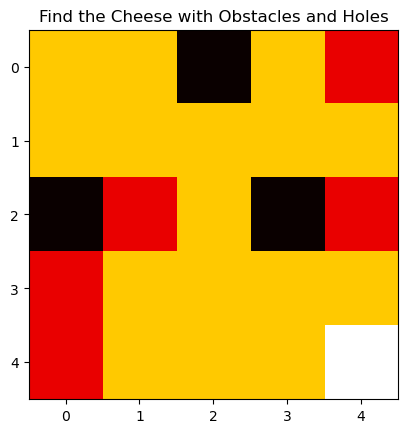

In [ ]:
# ------------STARE VYKRESLOVANI, PRESUNUTO DO agent_path.gif animace-------------------

# Po trénování můžeme zkontrolovat, jak agent reaguje v testovacích epizodách
def test_agent():
    state = (0, 0)  # Začátek na pozici (0, 0)
    path = [state]
    total_reward = 0
    while state != cheese_pos:
        action = choose_action(state, epsilon=0)  # Bez prozkoumání, pouze exploatace
        next_state = (state[0] + actions[action][0], state[1] + actions[action][1])
        next_state = (max(0, min(grid_size-1, next_state[0])), max(0, min(grid_size-1, next_state[1])))
        
        # Zkontrolujeme, jestli agent narazil na překážku nebo díru
        if next_state in obstacles:
            next_state = state  # Agent zůstane na místě, pokud narazí na překážku
        if next_state in holes:
            next_state = state  # Agent zůstane na místě, pokud narazí na díru
        path.append(next_state)
        state = next_state
        total_reward += -1 if state != cheese_pos else 100
    print(f"Celková odměna: {total_reward}")
    return path

# Testování agenta po trénování
path = test_agent()
# Vizualizace trénovací cesty
for pos in path:
    result = plot_grid(pos, cheese_pos, obstacles, holes)
    plt.imshow(result, cmap='hot', interpolation='nearest')
    plt.title("Find the Cheese with Obstacles and Holes")
    plt.show()
    plt.pause(0.5)